
- Costruire un dataset di grafi di spin glass di piccola taglia (# basso di nodi) e studiare come l'apprendimento dell'energia da parte della GNN cambia al variare della connettività del grafo. Ad esempio fissando a 10 il numero di nodi, il numero di edges può essere cambiato da 9 (open spin glass chain) a 45 (fully connected spin glass) , magari provando 9, 15, 25, 45. Si costruiscono 4 dataset e si allena la stessa GNN separatamente su questi dataset in modo supervised per fare poi il confronto. (Livello medio)

- Costruire un dataset di grafi di spin glass a taglia e connettività fissati (# nodi non troppo alto). Studiare la comparazione tra l'apprendimento della magnetizzazione o dell'energia tra un MLP e una GNN.  Ovviamente in questo caso va ricavata la matrice di adiacenza e la matrice delle features a partire dai grafi per poter allenare l'MLP. (Livello medio)


In [51]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('Device: ', device)

def initialize_graph(L, periodic=True, n_dimensions=2):
    """
    Initialize a graph with L nodes
    """
    G = nx.Graph()
    for i in range(L):
        G.add_node(i, spin = np.random.choice([-1, 1]))
    
    for i in range(L):
        if periodic:
            for j in range(i+1, i+n_dimensions+1):
                G.add_edge(i, j % L, weight = np.random.rand()*2 -1 )
        else:
            for j in range(i+1, i+n_dimensions+1):
                if j < L:
                    G.add_edge(i, j, weight = np.random.rand()*2 -1 )
    return G
     

def plot_graph(G, pos=None):
    """
    Plot the graph with nodes colored according to their spin.
    """
    if pos is None:
        pos = nx.circular_layout(G)
    colors = ['blue' if G.nodes[i]["spin"] == 1 else 'red' for i in range(len(G.nodes) )]
    nx.draw(G, pos = pos, node_color=colors, with_labels=True)
    plt.show()
    

def calculate_energy(G, h=0 ):
    """
    Calculate the energy of the graph
    """
    E = 0
    E_h = 0
    for i, j in G.edges:
        E += G[i][j]["weight"] * G.nodes[i]["spin"] * G.nodes[j]["spin"]

    if h != 0:  # exclude the case of h = 0 to avoid floating point errors
        E_h = h * np.sum([G.nodes[i]["spin"] for i in G.nodes]) 


    return -E/2 - E_h  # divide by 2 to avoid double counting

Device:  cuda


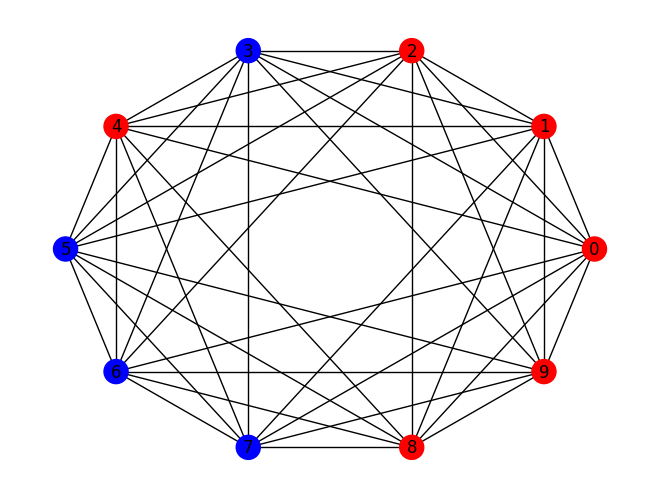

energy for this configuration:  -0.5754696616175957


In [2]:
G = initialize_graph(10, periodic=True, n_dimensions=4)
plot_graph(G)
h = 0
print("energy for this configuration: " , calculate_energy(G, h))

In [3]:
#extract the adjacency matrix
A = nx.adjacency_matrix(G).todense()
print(A)
print()
#extract the node features
X = torch.tensor([G.nodes[i]["spin"] for i in G.nodes]).float().view(-1, 1)
print(X)
print()

M = np.concatenate([X, A], axis=1)

print(M)


[[ 0.          0.8198504  -0.94322294 -0.10277351  0.07062833  0.
   0.8587933   0.73384784  0.26075884  0.62280748]
 [ 0.8198504   0.          0.68009201 -0.92154318 -0.27300103 -0.2790464
   0.          0.17992132 -0.02850254 -0.66660473]
 [-0.94322294  0.68009201  0.         -0.97045349  0.82437881 -0.73965698
   0.23647662  0.          0.86717052  0.86374634]
 [-0.10277351 -0.92154318 -0.97045349  0.         -0.63088078 -0.33159631
  -0.85393798 -0.24192599  0.          0.14654464]
 [ 0.07062833 -0.27300103  0.82437881 -0.63088078  0.          0.76104671
   0.58661633 -0.80076629  0.66704724  0.        ]
 [ 0.         -0.2790464  -0.73965698 -0.33159631  0.76104671  0.
  -0.57766241 -0.09712203  0.46355066  0.30846162]
 [ 0.8587933   0.          0.23647662 -0.85393798  0.58661633 -0.57766241
   0.          0.06999813 -0.02078614 -0.21894169]
 [ 0.73384784  0.17992132  0.         -0.24192599 -0.80076629 -0.09712203
   0.06999813  0.          0.32279273  0.4612332 ]
 [ 0.26075884 -0.

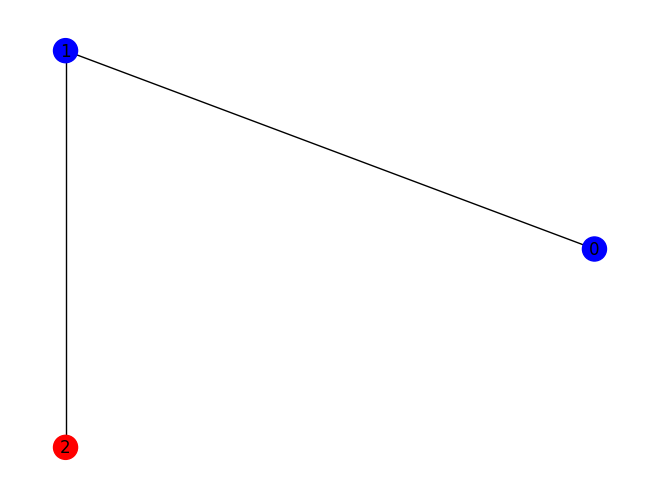

Data object:  Data(x=[3, 1], edge_index=[2, 2], y=[1], edge_weight=[2])
tensor([[0, 1],
        [1, 2]])
Features:  tensor([[ 1.],
        [ 1.],
        [-1.]])
Edges weight:  tensor([-0.8173,  0.3947])
The general graph feature:  tensor([0.6060])


In [4]:
n_nodes = 3
h = 0
periodic = False
n_dimensions = 1

G = initialize_graph(n_nodes,periodic=periodic, n_dimensions=n_dimensions)
plot_graph(G)
X = torch.tensor([G.nodes[i]["spin"] for i in G.nodes]).float().view(-1, 1)


# create a torch geometric data object from G, using the from_networkx function 
data = Data(x = X, 
            edge_index = torch.tensor(np.array(G.edges).T, dtype=torch.long),
            edge_weight = torch.tensor([G[i][j]["weight"] for i, j in G.edges], dtype=torch.float),
            y = torch.tensor([calculate_energy(G, h)], dtype=torch.float) ) 
print('Data object: ', data)

print(data.edge_index)

print('Features: ', data.x)
print('Edges weight: ', data.edge_weight)
print('The general graph feature: ', data.y)



In [5]:
# create a dataset with the energy as label

dataset = []
graphs = []

n_nodes = 6
h = 0
periodic = True
n_dimensions = 2

for i in range(10000):
    G = initialize_graph(n_nodes, periodic=periodic, n_dimensions=n_dimensions)
    #A = nx.adjacency_matrix(G).todense()
    X = torch.tensor([G.nodes[i]["spin"] for i in G.nodes]).float().view(-1, 1)

    graphs.append(G)
    dataset.append(
        Data(x = X, 
            edge_index = torch.tensor(np.array(G.edges).T, dtype=torch.long),
            edge_weight = torch.tensor([G[i][j]["weight"] for i, j in G.edges], dtype=torch.float),
            y = torch.tensor([calculate_energy(G, h)], dtype=torch.float) ) )   

In [6]:
dataset[0].num_node_features

1

In [47]:
# GNN model
import torch
import torch.nn.functional as F
from torch_geometric.nn import GraphConv

import torch
import matplotlib.pyplot as plt
from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.profile import get_model_size
from torch.nn import Softmax, Linear
from torch_geometric.nn import global_max_pool, SAGEConv
from torch_geometric.loader import DataLoader

def plotting(title, x, y):
    plt.figure(figsize=(10, 5))
    plt.title(title, fontsize=20)
    plt.plot(x, y, color='#88CCEE', linewidth=3)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel(title, fontsize=18)
    plt.grid(True)
    # plt.legend(fontsize=18)
    # plt.savefig('Graph_mnist'+ title +'.png')
    plt.show()


def accuracy(prediction, y):
    """Calculate accuracy."""
    return ((prediction.argmax(dim=1) == y).sum() / len(y)).item()




class GNN(torch.nn.Module):
    def __init__(self,hidden_channels_1=16, hidden_channels_2=16, hidden_channels_3=16, hidden_linear=16,
                 lr = 1e-5, weight_decay=1e-3, dropout=0.5, num_node_features=1, num_classes=1):
        super(GNN, self).__init__()
        self.conv1 = GraphConv(num_node_features,hidden_channels_1)
        self.conv2 = GraphConv(hidden_channels_1, hidden_channels_2)
        self.conv3 = GraphConv(hidden_channels_2, hidden_channels_3)

        self.pool = global_max_pool

        self.linear1 = Linear(hidden_channels_3, hidden_linear)
        self.linear2 = Linear(hidden_linear, num_classes)

        

        self.dropout = dropout

        # we should consider also batch normalization in case of overfitting



        # Optimizer:
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        # Loss function:
        self.criterion = torch.nn.MSELoss()

        
    
    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = F.leaky_relu(self.conv1(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv2(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv3(x, edge_index, edge_weight))


        x = self.pool(x, data.batch) # [n_nodes*n_graph_of_the_batch, n_features] -> [n_graph_of_the_batch, n_features]


        #x = self.dropout(x)

        x = F.leaky_relu(self.linear1(x))
        out = self.linear2(x)

        return out
    

    
    def train_step(self, data):
        # Reset gradients
        self.optimizer.zero_grad()
        # Passing the node features and the connection info
        prediction = self.forward(data)
        # Calculating the loss and gradients
        loss = self.criterion(prediction, data.y)
        loss.backward()
        # Update using the gradients
        self.optimizer.step()
        
        return loss.item()
    




In [52]:
import seaborn as sns

palette = sns.color_palette("coolwarm", as_cmap=True)

def plot_loss(epoch, train_losses, test_losses, figsize = (10, 5)):
    fig = plt.figure(figsize=(figsize))
    plt.plot(epoch, train_losses, label='Training Loss')
    plt.plot(epoch, test_losses, label='Test Loss')
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.title('Losses', fontsize=20)
    plt.legend(fontsize=18)
    plt.grid(True)
    plt.savefig('Graph_mnist_losses.png')
    plt.show()
    return fig


def train_model(model, train_loader, test_loader, num_epochs):
    epochs = range(1, num_epochs+1)
    train_losses, test_losses = [], []
    print('Training ...')
    for epoch in epochs:
        loss_per_epoch = []
        test_loss_per_epoch = []

        for i, mini_batch in enumerate(train_loader):
            mini_batch.to(device)
            train_loss = model.train_step(mini_batch)
            loss_per_epoch.append(train_loss)

        train_losses.append(sum(loss_per_epoch)/len(loss_per_epoch))


        with torch.no_grad():
            """Evaluate the model on test set"""
            for i, mini_batch in enumerate(test_loader):
                mini_batch.to(device)
                prediction = model.forward(mini_batch)
                prediction.to('cpu')
                test_loss = model.criterion(prediction, mini_batch.y).item()
                test_loss_per_epoch.append(test_loss)

            test_losses.append(sum(test_loss_per_epoch)/len(test_loss_per_epoch))


        print(f"Ep {epoch} \t| Loss {round(train_losses[-1], 5)} \t| Test Loss {round(test_losses[-1], 5)}")

        fig = plot_loss(epochs, train_losses, test_losses)
    return fig, train_losses, test_losses

In [59]:
from torch_geometric.loader import DataLoader

# training hyperparameters
batch_size = 32
num_epochs = 2
lr = 1e-5
weight_decay = 1e-3
dropout = 0.5

# model hyperparameters
hidden_channels_1 = 32
hidden_channels_2 = 32
hidden_channels_3 = 32
hidden_linear = 32



# Creating dataloaders for storing and shuffling training data:
train_loader = DataLoader(dataset=dataset[:int(len(dataset) * 0.8)], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=dataset[int(len(dataset) * 0.8):], batch_size=1, shuffle=False)

#define the model with the hyperparameters
model = GNN(hidden_channels_1=hidden_channels_1, 
            hidden_channels_2=hidden_channels_2, 
            hidden_channels_3=hidden_channels_3, 
            hidden_linear=hidden_linear,
            lr=lr, weight_decay=weight_decay, dropout=dropout)
model.to(device);

In [60]:
# start the training 
fig, train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs)


Training ...
